# Load the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Load the dataset

In [3]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]

data_train = fetch_20newsgroups(subset='train', 
                                remove=('headers', 'footers', 'quotes'),
                                categories=categories, 
                                shuffle=True, random_state=42)

df_train = pd.DataFrame(data_train.data)
labels_train = data_train.target

data_test = fetch_20newsgroups(subset='test', 
                               remove=('headers', 'footers', 'quotes'),
                               categories=categories, 
                               shuffle=True, random_state=42)

df_test = pd.DataFrame(data_test.data)
labels_test= data_test.target

In [4]:
data_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [5]:
print(pd.DataFrame(labels_train).value_counts())


2    593
1    584
0    480
3    377
dtype: int64


# Add Custom Stopwords

In [6]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopw = stopwords.words('english')
file1 = open('stopwords.txt','r')

# Use this to read file content as a stream:
line = file1.read()
customstopwords = line.split()
stopw.extend(customstopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing functions

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk import pos_tag

def steming(x):
    from nltk.stem import PorterStemmer
    
    #ps = PorterStemmer()
    stemmer = nltk.stem.SnowballStemmer('english')
    
    words = word_tokenize(x)
    
    refined_sent = [stemmer.stem(w) for w in words ]
    #print(refined_sent)
    return ' '.join(refined_sent) 

def lemmatizer(x):
    from collections import defaultdict
    from nltk.stem.wordnet import WordNetLemmatizer
    
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    
    tag_list = ['IN','VBN','RB','RBR','RBS','JJR','DT','UH','WDT','WP','WP$','WRB','VBG','MD','PRP','PRP$','CC']
    
    
    #words = word_tokenize(x)
    words = x.split(' ')
    lemma_function = WordNetLemmatizer()
    #refined_sent = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(words)]
    #refined_sent = [lemma_function.lemmatize(token) for token, tag in pos_tag(words) if tag not in tag_list ]
    refined_sent = list()
    for token, tag in pos_tag(words):
        if  len(token) > 3 :
            if tag not in tag_list:
                tag_l = tag.lower()
                if tag.lower() in ['a', 'r', 'n', 'v']:
                    refined_sent.append(lemma_function.lemmatize(token,tag_l))
                else:
                    refined_sent.append(lemma_function.lemmatize(token))
                             
    return ' '.join(refined_sent) 


def remove_sentence(x):
    x = x.split("\n")
    refined_sent = [sent for sent in x if not (sent.strip().startswith("from") \
                                       or sent.strip().startswith("subject") \
                                       or sent.strip().startswith('nntp') \
                                       or sent.strip().startswith('organization'))] 
    
    return ' '.join(refined_sent)

def stop_words(x):
    x = x.replace('\r\n',' ')
    terms = x.split(' ')
    refined_sent = [w.strip() for w in terms if (w.strip() not in stopw)  and (len(w.strip()) > 2)]
    
    #for w in terms:
    #    print(w)
    #    if (w.strip() not in stopw):
    #        print("inside if")
    #print(refined_sent)
    return  ' '.join(refined_sent)



In [8]:
 # Convert into lower case character
df_train[0] = df_train[0].map(lambda x: x.lower())

# remove from, subject, nntp and organization details from the text
df_train[0] = df_train[0].apply(lambda x: remove_sentence(x))

#replace web addresses with null value
df_train[0] = df_train[0].map(lambda x: re.sub(r'[\w\.-]+@[\w\.-]+','',x))

#remove all the special characters
df_train[0] = df_train[0].map(lambda x: re.sub('[,\.!?_=()"|><*]', '', x))

#Remove numeric values
df_train[0] = df_train[0].map(lambda x: re.sub(r'[0-9]+', '', x))

#Apply lemmization
df_train[0] = df_train[0].apply(lambda x: lemmatizer(x))

#Remove stopwords
df_train[0] = df_train[0].apply(lambda x: stop_words(x)) 

#pd.set_option('display.max_colwidth', -1)

# Convert the text into TFIDF Vector

<b> max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" </b>

max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
max_df = 25 means "ignore terms that appear in more than 25 documents".

<b> min_df is used for removing terms that appear too infrequently. For example: </b>

min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
min_df = 5 means "ignore terms that appear in less than 5 documents".


In [9]:
# Convert to TF-IDF format
#vectorizer_train= TfidfVectorizer(max_df=0.50, min_df=0.07, stop_words='english', use_idf=True)
vectorizer_train = TfidfVectorizer(max_df=0.50, min_df=0.01, stop_words=None,use_idf=True,
                                   max_features = 1000,lowercase=False, ngram_range=(1,3))
X_train = vectorizer_train.fit_transform(df_train[0])
tfidf_feature_names = vectorizer_train.get_feature_names_out()
print(X_train.shape)
print(tfidf_feature_names)

(2034, 960)
['ability' 'able' 'absolute' 'accept' 'acceptable' 'access' 'account'
 'accurate' 'act' 'action' 'activity' 'actual' 'adam' 'addition'
 'additional' 'address' 'admit' 'advance' 'advanced' 'advantage' 'agency'
 'algorithm' 'alive' 'allen' 'allow' 'allows' 'alternative' 'america'
 'american' 'ames' 'amiga' 'amount' 'analysis' 'and' 'animal' 'animation'
 'anonymous' 'answer' 'answer question' 'anti' 'anything' 'apollo'
 'appear' 'appears' 'application' 'apply' 'appreciate' 'appreciated'
 'approach' 'appropriate' 'april' 'archive' 'archive name' 'are' 'area'
 'argue' 'argument' 'article' 'asked' 'aspect' 'assume' 'assumption'
 'astronomy' 'atheism' 'atheist' 'atmosphere' 'attack' 'attempt'
 'attitude' 'author' 'authority' 'avoid' 'aware' 'back' 'background'
 'ball' 'bank' 'base' 'based' 'basic' 'basis' 'became' 'become' 'becomes'
 'begin' 'behavior' 'belief' 'believe' 'believer' 'benefit' 'best' 'bible'
 'biblical' 'bill' 'billion' 'bit' 'black' 'board' 'bobby' 'body' 'book'
 '

# Function to plot top n words obtained by the MODEL

In [10]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# LDA Model

In [11]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components=4, random_state=0)
clf = lda.fit(X_train.toarray(), labels_train)
clf_l = clf.transform(X_train.toarray())


In [12]:
 for idx,topic in enumerate(lda.components_):
    print(topic.argsort()[-1])

140
635
805
312


In [13]:
lda.components_[0][1]

4.210683929219332

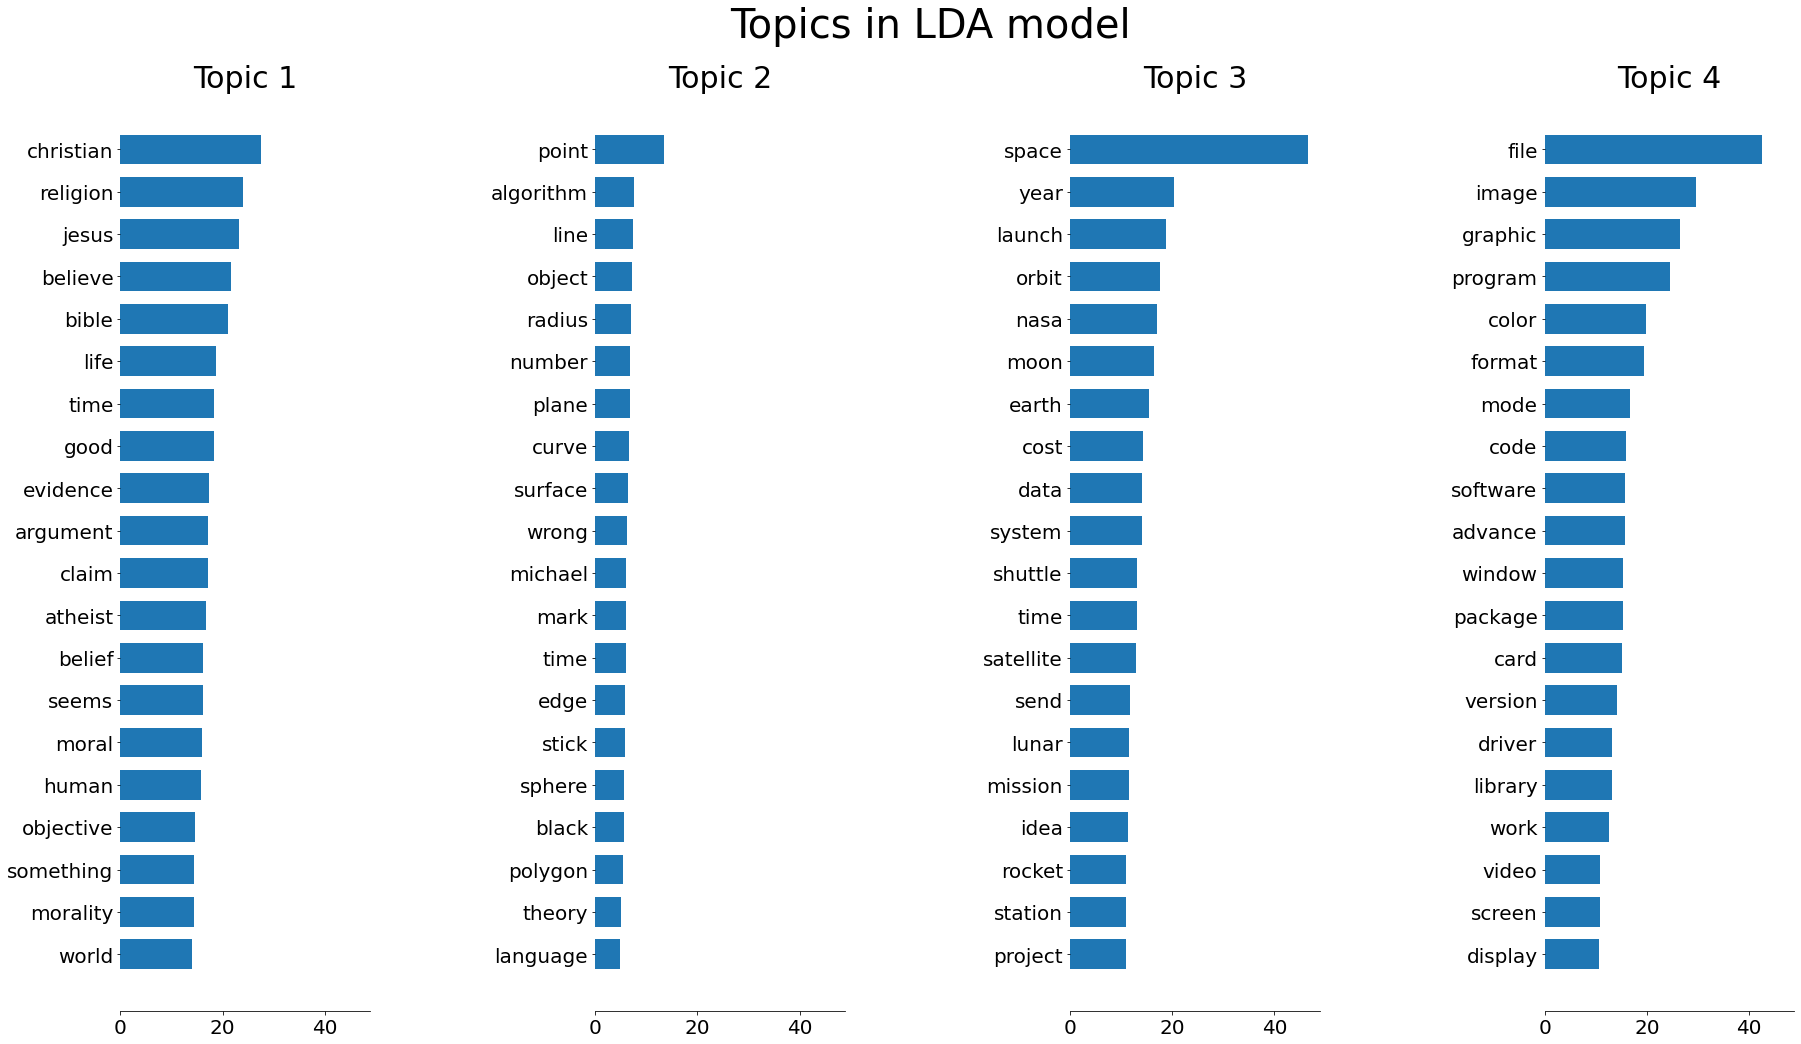

In [14]:
n_top_words = 20
plot_top_words(lda, tfidf_feature_names, n_top_words, "Topics in LDA model")

# PLSA Model

In [15]:
#Number of topcis
from sklearn.decomposition import NMF
no_of_topics = 4
model = NMF(n_components = no_of_topics, init='nndsvd',regularization='components', random_state = 111 )
W1 = model.fit_transform(X_train)
H1 = model.components_

C:\Users\venka\miniconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1432: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


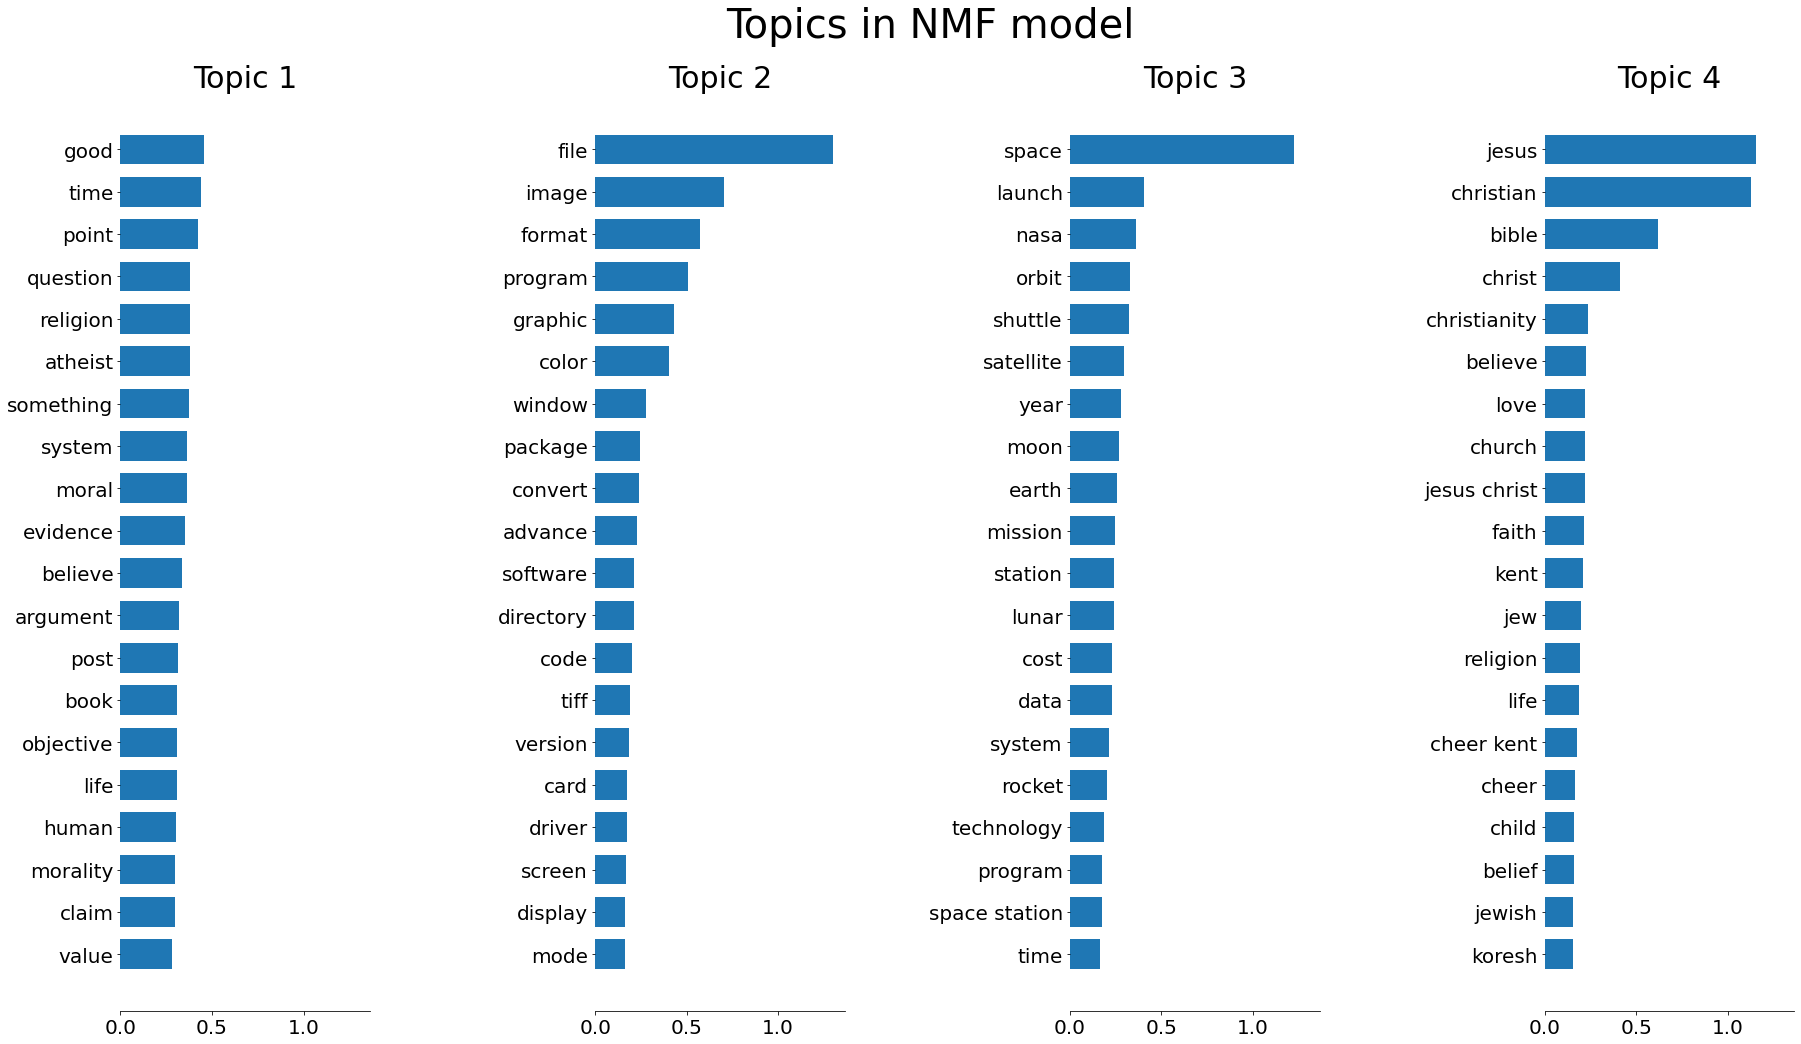

In [16]:
tfidf_feature_names = vectorizer_train.get_feature_names_out()
n_top_words = 20
plot_top_words(
    model, tfidf_feature_names, n_top_words, "Topics in NMF model"
)